In [1]:
#load benchmarks problems

import numpy as np

eqc = np.load('eqcS.npy',allow_pickle=True).item() 
class prb:   #this will be your black box function
    def __init__(self,prob,noisy_level):
        # function for generating data
        self.func=prob['func']
        # number of constraints
        self.n_con=prob['n_con']
        # noise level
        self.nl=noisy_level
        # constraints
        self.con=[]
        for i in range(self.n_con):
            self.con.append(prob['con'+str(i+1)])
    def datcol(self,x):
        try:
            # eval takes string type input and evaluates python code. Input can be
            #a mathematical function or a python function which will be called.
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)
    def constraint(self,x):
        # Appears to evaluate if the constraints are satisfied
        #returns 1 if all constraints are satisfied, else -1
        try:     
            m,n=np.shape(x)
        except:
            x = np.array([x])
            m,n=np.shape(x)
        y=np.empty((self.n_con))
        for i in range(self.n_con):
            y[i]=eval(self.con[i])     
        if y.all() == 1.:
            label = 1.
        else:
            label = -1.
        return label
    
bcp=np.load('bcp8.npy',allow_pickle=True).item()

class benchmark:
    def __init__(self,func,noisy_level):
        self.func = str(func)
        self.nl = noisy_level
    def datcol(self,x):
        try:
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)

# Helper functions from Lucas

In [2]:
# Find and replace function for editing function strings
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create usable form of the function to pass to optimizers
def get_usable_fxn(dimension: int, fxn_form: str):
    find_rep_list = [('x[:,{}]'.format(dimension-1-i),'x["{}"]'.format(dimension-1-i)) for i in range(dimension)]
    opt_form = multiple_replace(fxn_form, find_rep_list)
    return opt_form

# Create search space
def create_search_space(dimension: int, xlb: list, xub: list, resolution: int = 100):
    search_space = {str(i):np.linspace(xlb[i],xub[i],resolution) for i in range(dimension)}
    return search_space

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer - there is probably a better way to do this, possibly using wrappers. Not worth time right now.
def create_parent_fxn(search_space,opt_form):
    search_space = search_space
    opt_form = opt_form
    def objective_fxn(search_space):
        #clear_output(wait=True)
        x = search_space
        return -1*eval(opt_form)
    return objective_fxn

# Additional Helper Functions

In [3]:
def get_valid_problems(names):
    """ 
    Some provided solutions may be invalid. This function returns valid/invalid solutions
    """

    valid_problems = []
    invalid_problems = []
    for name in names: 
        dims = bcp[f'{name}']['n']
        try:
            assert len(bcp[f'{name}']['xub']) == dims and len(bcp[f'{name}']['xlb']) == dims
            assert len(bcp[f'{name}']['xopt']) == dims 
            valid_problems.append(name)
        except:
            invalid_problems.append(name)
            continue

    print(f"There are {len(valid_problems)} valid problems and {len(invalid_problems)} invalid problems")
    
    return valid_problems, invalid_problems

def get_perturbed_solutions(test_fxn):

    """
    Returns perturbed optimal solutions for a given input problem 
    """

    dims = test_fxn['n']
    perturbed_solutions = []

    for dim in range(dims):
        opt = test_fxn['xopt'][dim]       
        perturbation = np.random.uniform(-5, 5) / 100
        if opt != 0.0: perturbed_solution = np.array([opt + opt*perturbation])
        else: perturbed_solution = np.array([perturbation])
        perturbed_solutions.append(perturbed_solution)

    return np.concatenate(perturbed_solutions)

def get_all_initial_guesses(names):

    """
    Returns perturbed initial guesses for all valid problems as a list of dicts
    """

    valid_problems, invalid_problems = get_valid_problems(names)
    all_initial_guesses = []

    for problem in valid_problems:
        test_fxn = bcp[f'{problem}']
        dims = test_fxn['n']
        perturbed_solution = get_perturbed_solutions(test_fxn).astype(float)
        optimal_solution = test_fxn['xopt'].astype(float)
        percent_diff = np.divide(abs(perturbed_solution - optimal_solution), abs(optimal_solution), 
                                out=np.zeros_like(optimal_solution), where=optimal_solution!=0) * 100.0
        assert max(percent_diff) <= 5 # we sampled perturbations from uniform(-5,5)
        assert len(perturbed_solution) == dims

        initial_guess = {str(i):perturbed_solution[i] for i in range(dims)}
        all_initial_guesses.append(initial_guess)

    return all_initial_guesses, valid_problems, invalid_problems


def get_solutions(problems, solvers, all_initial_guesses):

    names = list(bcp.keys())
    final_solns = {}

    for problem in problems:

        test_fxn = bcp[f'{problem}']
        fxn_form = test_fxn['func']
        xlb = test_fxn['xlb']
        xub = test_fxn['xub']
        ndim = test_fxn['n']

        opt_form = get_usable_fxn(ndim, fxn_form)
        search_space = create_search_space(ndim, xlb, xub, resolution=100)
        fxn = create_parent_fxn(search_space,opt_form)

        initial_guess = all_initial_guesses[names.index(f'{problem}')]
        initialize={"warm_start":[initial_guess]}

        optimum = {}
        for f in solvers:
            opt = f(search_space) # initialize optimizer
            opt.search(fxn, n_iter=2500) # run optimizer
            #opt.search_data.to_csv('./{}.txt'.format(f.__name__), sep='\t', index=False)
            #optimum[f.__name__] = (-1*opt.best_score, opt.best_para)
            optimum[f.__name__] = opt.best_para

        opts = ['Solver\tOptimum']
        for i in optimum.keys():
            tmp_opt = optimum[i]
            opts += ['{}\t{}'.format(i,tmp_opt)]
        with open(f'{problem}-refinement.txt', 'w') as f:
            print('\n'.join(opts),file=f)

        final_solns[f'{problem}'] = optimum

    return final_solns


def get_solver_names(solvers):

    """ 
    Function to process strings of solvers
    """

    solver_names = []
    for i in range(len(solvers)):
        solver_name = str(solvers[i])
        # All solver names are after 4th "." 
        idx = solver_name.find(".", solver_name.find(".", solver_name.find(".", solver_name.find(".") + 1) + 1) + 1)

        # Select the substring after the 4th dot
        solver_name = solver_name[idx+1:]
        solver_name = solver_name.replace("'", "")
        solver_name = solver_name.replace(">", "")
        solver_names.append(solver_name)
    
    return solver_names

def get_maes(problems, solver_names, solver_solutions):

    """
    Get MAEs for a list of specified problems, ground truth solutions, and solution obtained
    by a list of solvers
    """
    from sklearn.metrics import mean_absolute_error

    maes = {}

    for solver_name in solver_names:
        solver_opts = [v[f'{solver_name}'] for v in solver_solutions.values()]
        true_opts = [bcp[f'{problem}']['yopt'] for problem in problems]
        mae = mean_absolute_error(solver_opts, true_opts)
        maes[f'{solver_name}'] = mae

    return maes

def create_function(problem_idx, func_string, valid_problems, invalid_problems):
    """
    This could be a duplicate of Lucas' function? Doesn't seem like it but TOCHECK
    """
    filtered_bcp = {key: value for key, value in bcp.items() if not any(s in key for s in invalid_problems)}

    for i in range(len(filtered_bcp[valid_problems[problem_idx]]['xopt'])):
        func_string = func_string.replace(f"x[:,{i}]",f"x[{str(i)}]")

    function_def = "def problem_function(x):\n    return " + func_string
    exec(function_def, globals())

    return globals()['problem_function']

def get_x_values(initial_guesses):
    x = []
    for value in initial_guesses.values():
        x.append(value)
    return x

def evaluate_refinement(problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus):

    filtered_bcp = {key: value for key, value in bcp.items() if not any(s in key for s in invalid_problems)}

    for problem in problems:
        for solver in solver_names:          
            func_string = filtered_bcp[problem]['func'] 
            problem_idx = list(filtered_bcp.keys()).index(problem)
            initial_guesses = all_initial_guesses[problem_idx]
            initial_guesses  = get_x_values(initial_guesses)
            problem_function = create_function(problem_idx, func_string, valid_problems, invalid_problems)
            f_x0 = problem_function(initial_guesses)
            solver_output = solver_solutions[problem][solver]
            solver_output  = get_x_values(solver_output)
            f_solver = problem_function(solver_output)
            f_L = filtered_bcp[problem]['yopt']

            success = []

            for j in range(len(taus)):
                try:
                    assert f_x0 - f_solver >= (1 - taus[j])*(f_x0 - f_L)
                    success.append("successful")
                except:
                    success.append("not successful")
                    pass

            solver_solutions[problem][solver] = success
    
    return solver_solutions

def get_plot_dict(problems, solver_solutions, solver_names, taus):
    # New dictionary more intuitive in ordering 
    # Note to self: This is ugly ugly ugly code
    solver_solutions_inverted = {}

    for outer_key, inner_dict in solver_solutions.items():
        for inner_key, value in inner_dict.items():
            if inner_key not in solver_solutions_inverted:
                solver_solutions_inverted[inner_key] = {}
            solver_solutions_inverted[inner_key][outer_key] = value

    solver_solutions = solver_solutions_inverted 
    plot_dict = {}

    for solver in solver_names:
        num_successfuls = [0] * len(taus)
        for inner_list in solver_solutions[solver].values():
            for i, value in enumerate(inner_list):
                if value == 'successful':
                    num_successfuls[i] += 1

        fraction = [x / len(problems) for x in num_successfuls]
        plot_dict[solver] = fraction

    return plot_dict

# Refinement Ability (Objective 3)

Note: There are several changes that could be made to improve elegance and modularity. But with deadline approaching I'd just leave it as it is. I believe there are also some irregularities in the data files in terms of the initial guesses since my code works perfectly fine for a subset of problems and gives issues for others. 

In [4]:
from gradient_free_optimizers import EnsembleOptimizer
from gradient_free_optimizers import RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer
from gradient_free_optimizers import HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer
from gradient_free_optimizers import ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization
from gradient_free_optimizers import ForestOptimizer,BayesianOptimizer,TreeStructuredParzenEstimators,LipschitzOptimizer,DirectAlgorithm

names = list(bcp.keys())
all_initial_guesses, valid_problems, invalid_problems = get_all_initial_guesses(names)
# These problems don't give any issues (and potentially a few others)
problems = ['BeckerLago', 'AluffiPentini', 'trigobj', 'concha10', 'Hosaki', 'cube', 'denschnc', 'draperg', 'ex8_1_5', 'fermat_vareps',
            'Hartman3', 'hatfldb']
solvers = [RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer,
           DirectAlgorithm, ParticleSwarmOptimizer, EvolutionStrategyOptimizer, SimulatedAnnealingOptimizer, StochasticHillClimbingOptimizer]
solver_names = get_solver_names(solvers)
solver_solutions = get_solutions(problems, solvers, all_initial_guesses)
taus = [1e-1, 1e-2, 1e-4, 1e-6, 0e+0]
solver_refinement = evaluate_refinement(problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus)
plot_dict = get_plot_dict(problems, solver_refinement, solver_names, taus)

There are 263 valid problems and 2 invalid problems



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 1986305786  
 
   Evaluation time   : 0.12120223045349121 sec    [78.61 %]
   Optimization time : 0.032979726791381836 sec    [21.39 %]
   Iteration time    : 0.15418195724487305 sec    [16214.61 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 656430657  
 
   Evaluation time   : 0.0939476490020752 sec    [44.93 %]
   Optimization time : 0.11514782905578613 sec    [55.07 %]
   Iteration time    : 0.20909547805786133 sec    [11956.26 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 1797450482  
 
   Evaluation time   : 0.04045820236206055 sec    [26.1 %]
   Optimization time : 0.1145782470703125 sec    [73.9 %]
   Iteration time    : 0.15503644943237305 sec    [16125.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 1138754963  
 
   Evaluation time   : 0.037362098693847656 sec    [9.67 %]
   Optimization time : 0.3491494655609131 sec    [90.33 %]
   Iteration time    : 0.38651156425476074 sec    [6468.11 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 1230615552  
 
   Evaluation time   : 0.05120539665222168 sec    [20.36 %]
   Optimization time : 0.20023870468139648 sec    [79.64 %]
   Iteration time    : 0.25144410133361816 sec    [9942.57 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 873507511  
 
   Evaluation time   : 0.12209892272949219 sec    [52.68 %]
   Optimization time : 0.10968708992004395 sec    [47.32 %]
   Iteration time    : 0.23178601264953613 sec    [10785.81 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 1291091853  
 
   Evaluation time   : 0.0893096923828125 sec    [24.76 %]
   Optimization time : 0.2713494300842285 sec    [75.24 %]
   Iteration time    : 0.360659122467041 sec    [6931.75 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 4.994949494949495  
 
   Random seed: 1701636199  
 
   Evaluation time   : 0.04205155372619629 sec    [28.05 %]
   Optimization time : 0.10784244537353516 sec    [71.95 %]
   Iteration time    : 0.14989399909973145 sec    [16678.45 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 4.994949494949495  
 
   Random seed: 1015548582  
 
   Evaluation time   : 0.04798126220703125 sec    [24.61 %]
   Optimization time : 0.1469573974609375 sec    [75.39 %]
   Iteration time    : 0.19493865966796875 sec    [12824.55 iter/sec]
 


  1%|          | 30/2500 [00:00<00:00, 3589.07it/s, best_iter=30, best_pos=[49 50], best_score=-5.1015202530356945e-05]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 1409678210  
 
   Evaluation time   : 0.043905019760131836 sec    [25.45 %]
   Optimization time : 0.1286008358001709 sec    [74.55 %]
   Iteration time    : 0.17250585556030273 sec    [14492.26 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 1078217084  
 
   Evaluation time   : 0.04346418380737305 sec    [26.23 %]
   Optimization time : 0.1222677230834961 sec    [73.77 %]
   Iteration time    : 0.16573190689086914 sec    [15084.6 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.3523128770122108  
   Best parameter:
      '0' : -1.043508772622697  
      '1' : -0.011111111111111072  
 
   Random seed: 711880161  
 
   Evaluation time   : 0.08360099792480469 sec    [71.97 %]
   Optimization time : 0.03255796432495117 sec    [28.03 %]
   Iteration time    : 0.11615896224975586 sec    [21522.23 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1206157545  
 
   Evaluation time   : 0.04879426956176758 sec    [29.62 %]
   Optimization time : 0.1159517765045166 sec    [70.38 %]
   Iteration time    : 0.16474604606628418 sec    [15174.87 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 1301960518  
 
   Evaluation time   : 0.03694653511047363 sec    [24.73 %]
   Optimization time : 0.11245584487915039 sec    [75.27 %]
   Iteration time    : 0.14940237998962402 sec    [16733.33 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.3523230661938065  
   Best parameter:
      '0' : -1.0477377848724345  
      '1' : -0.011111111111111072  
 
   Random seed: 1676333203  
 
   Evaluation time   : 0.03722333908081055 sec    [8.7 %]
   Optimization time : 0.3906714916229248 sec    [91.3 %]
   Iteration time    : 0.42789483070373535 sec    [5842.56 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1329123659  
 
   Evaluation time   : 0.04073786735534668 sec    [16.94 %]
   Optimization time : 0.19977116584777832 sec    [83.06 %]
   Iteration time    : 0.240509033203125 sec    [10394.62 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1024666278  
 
   Evaluation time   : 0.0813744068145752 sec    [44.98 %]
   Optimization time : 0.09953665733337402 sec    [55.02 %]
   Iteration time    : 0.18091106414794922 sec    [13818.94 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 454111970  
 
   Evaluation time   : 0.06625580787658691 sec    [19.68 %]
   Optimization time : 0.2703723907470703 sec    [80.32 %]
   Iteration time    : 0.3366281986236572 sec    [7426.59 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.3523230661938065  
   Best parameter:
      '0' : -1.0477377848724345  
      '1' : 0.011111111111111072  
 
   Random seed: 1727096405  
 
   Evaluation time   : 0.042458295822143555 sec    [27.3 %]
   Optimization time : 0.11305570602416992 sec    [72.7 %]
   Iteration time    : 0.15551400184631348 sec    [16075.72 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 399771734  
 
   Evaluation time   : 0.04490089416503906 sec    [23.15 %]
   Optimization time : 0.149017333984375 sec    [76.85 %]
   Iteration time    : 0.19391822814941406 sec    [12892.03 iter/sec]
 


  7%|▋         | 186/2500 [00:00<00:00, 4984.06it/s, best_iter=186, best_pos=[56 50], best_score=0.3521110764673964] /Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: 0.3521110764673964  
   Best parameter:
      '0' : -1.0329362419983537  
      '1' : 0.011111111111111072  
 
   Random seed: 231640671  
 
   Evaluation time   : 0.06609892845153809 sec    [31.34 %]
   Optimization time : 0.14482784271240234 sec    [68.66 %]
   Iteration time    : 0.21092677116394043 sec    [11852.45 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 966233759  
 
   Evaluation time   : 0.04339718818664551 sec    [24.47 %]
   Optimization time : 0.13391780853271484 sec    [75.53 %]
   Iteration time    : 0.17731499671936035 sec    [14099.2 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 1501844216  
 
   Evaluation time   : 0.032843828201293945 sec    [55.57 %]
   Optimization time : 0.0262601375579834 sec    [44.43 %]
   Iteration time    : 0.059103965759277344 sec    [42298.35 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 1599152000  
 
   Evaluation time   : 0.028952360153198242 sec    [21.71 %]
   Optimization time : 0.10439181327819824 sec    [78.29 %]
   Iteration time    : 0.13334417343139648 sec    [18748.48 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 1253932734  
 
   Evaluation time   : 0.027452707290649414 sec    [19.81 %]
   Optimization time : 0.11110091209411621 sec    [80.19 %]
   Iteration time    : 0.13855361938476562 sec    [18043.56 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 723452944  
 
   Evaluation time   : 0.028442859649658203 sec    [5.53 %]
   Optimization time : 0.4859585762023926 sec    [94.47 %]
   Iteration time    : 0.5144014358520508 sec    [4860.02 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 1628948307  
 
   Evaluation time   : 0.02813720703125 sec    [12.75 %]
   Optimization time : 0.19256973266601562 sec    [87.25 %]
   Iteration time    : 0.22070693969726562 sec    [11327.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 237312254  
 
   Evaluation time   : 0.02761673927307129 sec    [27.47 %]
   Optimization time : 0.07293200492858887 sec    [72.53 %]
   Iteration time    : 0.10054874420166016 sec    [24863.56 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 1515233310  
 
   Evaluation time   : 0.025778770446777344 sec    [21.35 %]
   Optimization time : 0.09497427940368652 sec    [78.65 %]
   Iteration time    : 0.12075304985046387 sec    [20703.41 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 123480468  
 
   Evaluation time   : 0.03129839897155762 sec    [23.85 %]
   Optimization time : 0.09990811347961426 sec    [76.15 %]
   Iteration time    : 0.13120651245117188 sec    [19053.93 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 2099338766  
 
   Evaluation time   : 0.029378414154052734 sec    [17.23 %]
   Optimization time : 0.14113163948059082 sec    [82.77 %]
   Iteration time    : 0.17051005363464355 sec    [14661.89 iter/sec]
 


  0%|          | 2/2500 [00:00<00:01, 2153.69it/s, best_iter=2, best_pos=[19], best_score=3.418901120478621]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 904594909  
 
   Evaluation time   : 0.02819228172302246 sec    [19.02 %]
   Optimization time : 0.1200251579284668 sec    [80.98 %]
   Iteration time    : 0.14821743965148926 sec    [16867.11 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 898882084  
 
   Evaluation time   : 0.028075218200683594 sec    [19.3 %]
   Optimization time : 0.11740446090698242 sec    [80.7 %]
   Iteration time    : 0.14547967910766602 sec    [17184.53 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1872.966782402424  
   Best parameter:
      '0' : 0.5222222222222221  
      '1' : 0.5151515151515154  
 
   Random seed: 644536008  
 
   Evaluation time   : 0.4404609203338623 sec    [92.42 %]
   Optimization time : 0.03610372543334961 sec    [7.58 %]
   Iteration time    : 0.4765646457672119 sec    [5245.88 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -140.74605226532364  
   Best parameter:
      '0' : 0.7666666666666666  
      '1' : 0.49494949494949503  
 
   Random seed: 1401984711  
 
   Evaluation time   : 0.15463709831237793 sec    [57.06 %]
   Optimization time : 0.1163930892944336 sec    [42.94 %]
   Iteration time    : 0.2710301876068115 sec    [9224.06 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -6464.653000330931  
   Best parameter:
      '0' : 0.21111111111111103  
      '1' : 0.5555555555555556  
 
   Random seed: 688894856  
 
   Evaluation time   : 0.06223320960998535 sec    [34.14 %]
   Optimization time : 0.12007451057434082 sec    [65.86 %]
   Iteration time    : 0.18230772018432617 sec    [13713.08 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -3202.973299373901  
   Best parameter:
      '0' : 0.34444444444444433  
      '1' : 0.5353535353535355  
 
   Random seed: 1609220402  
 
   Evaluation time   : 0.045229434967041016 sec    [11.4 %]
   Optimization time : 0.35161375999450684 sec    [88.6 %]
   Iteration time    : 0.39684319496154785 sec    [6299.72 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -2444.546136125598  
   Best parameter:
      '0' : 1.1  
      '1' : 0.4747474747474749  
 
   Random seed: 751936490  
 
   Evaluation time   : 0.08933043479919434 sec    [30.42 %]
   Optimization time : 0.20436763763427734 sec    [69.58 %]
   Iteration time    : 0.2936980724334717 sec    [8512.14 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -960487.8466552099  
   Best parameter:
      '0' : 0.3666666666666667  
      '1' : 0.3333333333333335  
 
   Random seed: 2108161175  
 
   Evaluation time   : 0.4840865135192871 sec    [82.39 %]
   Optimization time : 0.1034536361694336 sec    [17.61 %]
   Iteration time    : 0.5875401496887207 sec    [4255.03 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -33158.46590142025  
   Best parameter:
      '0' : 0.011111111111111072  
      '1' : 0.696969696969697  
 
   Random seed: 190075817  
 
   Evaluation time   : 0.039353370666503906 sec    [29.86 %]
   Optimization time : 0.09242558479309082 sec    [70.14 %]
   Iteration time    : 0.13177895545959473 sec    [18971.16 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -141063.42794742345  
   Best parameter:
      '0' : 0.47777777777777786  
      '1' : 0.49494949494949503  
 
   Random seed: 1213043927  
 
   Evaluation time   : 0.06589412689208984 sec    [39.59 %]
   Optimization time : 0.10054993629455566 sec    [60.41 %]
   Iteration time    : 0.1664440631866455 sec    [15020.06 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1118.3972516974957  
   Best parameter:
      '0' : 0.5  
      '1' : 0.5151515151515154  
 
   Random seed: 1325043566  
 
   Evaluation time   : 0.09328293800354004 sec    [39.19 %]
   Optimization time : 0.14473915100097656 sec    [60.81 %]
   Iteration time    : 0.2380220890045166 sec    [10503.23 iter/sec]
 


  3%|▎         | 65/2500 [00:00<00:00, 3034.41it/s, best_iter=65, best_pos=[84 74], best_score=-140.74605226532364]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -140.74605226532364  
   Best parameter:
      '0' : 0.7666666666666666  
      '1' : 0.49494949494949503  
 
   Random seed: 1263916326  
 
   Evaluation time   : 0.08487462997436523 sec    [39.91 %]
   Optimization time : 0.12779831886291504 sec    [60.09 %]
   Iteration time    : 0.21267294883728027 sec    [11755.14 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1118.3972516974957  
   Best parameter:
      '0' : 0.5  
      '1' : 0.5151515151515154  
 
   Random seed: 1887867104  
 
   Evaluation time   : 0.10264015197753906 sec    [44.55 %]
   Optimization time : 0.1277468204498291 sec    [55.45 %]
   Iteration time    : 0.23038697242736816 sec    [10851.31 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 451850447  
 
   Evaluation time   : 0.11577415466308594 sec    [79.97 %]
   Optimization time : 0.028998136520385742 sec    [20.03 %]
   Iteration time    : 0.14477229118347168 sec    [17268.5 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 528672624  
 
   Evaluation time   : 0.05432891845703125 sec    [32.07 %]
   Optimization time : 0.11506509780883789 sec    [67.93 %]
   Iteration time    : 0.16939401626586914 sec    [14758.49 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 219324641  
 
   Evaluation time   : 0.04006814956665039 sec    [26.03 %]
   Optimization time : 0.11383938789367676 sec    [73.97 %]
   Iteration time    : 0.15390753746032715 sec    [16243.52 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1525694040  
 
   Evaluation time   : 0.03817009925842285 sec    [8.33 %]
   Optimization time : 0.42025113105773926 sec    [91.67 %]
   Iteration time    : 0.4584212303161621 sec    [5453.5 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1619868183  
 
   Evaluation time   : 0.05043745040893555 sec    [19.53 %]
   Optimization time : 0.20776748657226562 sec    [80.47 %]
   Iteration time    : 0.25820493698120117 sec    [9682.23 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1383701015  
 
   Evaluation time   : 0.13246774673461914 sec    [52.8 %]
   Optimization time : 0.11841940879821777 sec    [47.2 %]
   Iteration time    : 0.2508871555328369 sec    [9964.64 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.345782612790615  
   Best parameter:
      '0' : 4.004040403990354  
      '1' : 2.0020202019901716  
 
   Random seed: 1064511803  
 
   Evaluation time   : 0.09275174140930176 sec    [25.48 %]
   Optimization time : 0.2712242603302002 sec    [74.52 %]
   Iteration time    : 0.36397600173950195 sec    [6868.58 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.345782612790615  
   Best parameter:
      '0' : 4.004040403990354  
      '1' : 2.0020202019901716  
 
   Random seed: 747227766  
 
   Evaluation time   : 0.03883934020996094 sec    [27.63 %]
   Optimization time : 0.10172700881958008 sec    [72.37 %]
   Iteration time    : 0.14056634902954102 sec    [17785.2 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 296470859  
 
   Evaluation time   : 0.04869985580444336 sec    [25.21 %]
   Optimization time : 0.14450311660766602 sec    [74.79 %]
   Iteration time    : 0.19320297241210938 sec    [12939.76 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1951222020  
 
   Evaluation time   : 0.10549449920654297 sec    [43.05 %]
   Optimization time : 0.13954687118530273 sec    [56.95 %]
   Iteration time    : 0.2450413703918457 sec    [10202.36 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1786003359  
 
   Evaluation time   : 0.04885601997375488 sec    [25.72 %]
   Optimization time : 0.1410994529724121 sec    [74.28 %]
   Iteration time    : 0.189955472946167 sec    [13160.98 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 1431172299  
 
   Evaluation time   : 0.07706546783447266 sec    [69.5 %]
   Optimization time : 0.03381705284118652 sec    [30.5 %]
   Iteration time    : 0.11088252067565918 sec    [22546.38 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 1360912158  
 
   Evaluation time   : 0.048325300216674805 sec    [29.39 %]
   Optimization time : 0.11608314514160156 sec    [70.61 %]
   Iteration time    : 0.16440844535827637 sec    [15206.03 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00019895696264701708  
   Best parameter:
      '0' : 0.9868686869081617  
      '1' : 0.9606060607309393  
 
   Random seed: 1390530558  
 
   Evaluation time   : 0.037256479263305664 sec    [24.28 %]
   Optimization time : 0.11619329452514648 sec    [75.72 %]
   Iteration time    : 0.15344977378845215 sec    [16291.98 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0018045579027250792  
   Best parameter:
      '0' : 0.9646464646850506  
      '1' : 0.900000000117  
 
   Random seed: 1983179566  
 
   Evaluation time   : 0.03507423400878906 sec    [14.03 %]
   Optimization time : 0.21488380432128906 sec    [85.97 %]
   Iteration time    : 0.24995803833007812 sec    [10001.68 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0010711497265787234  
   Best parameter:
      '0' : 1.0313131313543837  
      '1' : 1.0959595961020705  
 
   Random seed: 1770109507  
 
   Evaluation time   : 0.040167808532714844 sec    [16.61 %]
   Optimization time : 0.20162129402160645 sec    [83.39 %]
   Iteration time    : 0.2417891025543213 sec    [10339.59 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 172256366  
 
   Evaluation time   : 0.08973383903503418 sec    [43.38 %]
   Optimization time : 0.11713910102844238 sec    [56.62 %]
   Iteration time    : 0.20687294006347656 sec    [12084.71 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212416747020108e-06  
   Best parameter:
      '0' : 1.0010101010501413  
      '1' : 1.0030303031606969  
 
   Random seed: 928380072  
 
   Evaluation time   : 0.06349015235900879 sec    [18.25 %]
   Optimization time : 0.28432345390319824 sec    [81.75 %]
   Iteration time    : 0.34781360626220703 sec    [7187.76 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00037222696822377375  
   Best parameter:
      '0' : 0.9828282828675959  
      '1' : 0.9484848486081515  
 
   Random seed: 1911091215  
 
   Evaluation time   : 0.04037928581237793 sec    [26.62 %]
   Optimization time : 0.11130237579345703 sec    [73.38 %]
   Iteration time    : 0.15168166160583496 sec    [16481.89 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 246139214  
 
   Evaluation time   : 0.047502756118774414 sec    [23.44 %]
   Optimization time : 0.15517663955688477 sec    [76.56 %]
   Iteration time    : 0.20267939567565918 sec    [12334.75 iter/sec]
 


  8%|▊         | 208/2500 [00:00<00:00, 7327.03it/s, best_iter=208, best_pos=[43 30], best_score=-0.00019895696264701708]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 546151396  
 
   Evaluation time   : 0.047672271728515625 sec    [24.98 %]
   Optimization time : 0.1432034969329834 sec    [75.02 %]
   Iteration time    : 0.19087576866149902 sec    [13097.52 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 521040217  
 
   Evaluation time   : 0.04454183578491211 sec    [25.21 %]
   Optimization time : 0.13212800025939941 sec    [74.79 %]
   Iteration time    : 0.17666983604431152 sec    [14150.69 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016888113374942447  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0070707070807778  
 
   Random seed: 465230263  
 
   Evaluation time   : 0.09633445739746094 sec    [74.79 %]
   Optimization time : 0.03247380256652832 sec    [25.21 %]
   Iteration time    : 0.12880825996398926 sec    [19408.69 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1214565016  
 
   Evaluation time   : 0.05406475067138672 sec    [30.34 %]
   Optimization time : 0.12415289878845215 sec    [69.66 %]
   Iteration time    : 0.17821764945983887 sec    [14027.79 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016578324489769646  
   Best parameter:
      '0' : 1.011111111111111  
      '1' : 0.9949494949594444  
 
   Random seed: 1145189899  
 
   Evaluation time   : 0.039227962493896484 sec    [24.76 %]
   Optimization time : 0.11922049522399902 sec    [75.24 %]
   Iteration time    : 0.1584484577178955 sec    [15778.0 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.02789928440526814  
   Best parameter:
      '0' : 1.1  
      '1' : 0.900000000009  
 
   Random seed: 1252745013  
 
   Evaluation time   : 0.036405086517333984 sec    [8.78 %]
   Optimization time : 0.37801647186279297 sec    [91.22 %]
   Iteration time    : 0.41442155838012695 sec    [6032.5 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.001395772076277389  
   Best parameter:
      '0' : 1.0333333333333332  
      '1' : 0.980808080817889  
 
   Random seed: 2050747185  
 
   Evaluation time   : 0.055318593978881836 sec    [20.26 %]
   Optimization time : 0.21773099899291992 sec    [79.74 %]
   Iteration time    : 0.27304959297180176 sec    [9155.85 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.020154149659236443  
   Best parameter:
      '0' : 0.8999999999999999  
      '1' : 1.0717171717278888  
 
   Random seed: 892821837  
 
   Evaluation time   : 0.09961414337158203 sec    [48.26 %]
   Optimization time : 0.10680270195007324 sec    [51.74 %]
   Iteration time    : 0.20641684532165527 sec    [12111.41 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 451793197  
 
   Evaluation time   : 0.1422884464263916 sec    [34.1 %]
   Optimization time : 0.2750062942504883 sec    [65.9 %]
   Iteration time    : 0.4172947406768799 sec    [5990.97 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.009762367692834797  
   Best parameter:
      '0' : 1.077777777777778  
      '1' : 0.9404040404134445  
 
   Random seed: 767672909  
 
   Evaluation time   : 0.048354148864746094 sec    [30.6 %]
   Optimization time : 0.10964679718017578 sec    [69.4 %]
   Iteration time    : 0.15800094604492188 sec    [15822.69 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 143854859  
 
   Evaluation time   : 0.04918193817138672 sec    [24.87 %]
   Optimization time : 0.14855456352233887 sec    [75.13 %]
   Iteration time    : 0.19773650169372559 sec    [12643.09 iter/sec]
 


  9%|▉         | 222/2500 [00:00<00:00, 6041.35it/s, best_iter=222, best_pos=[95 48], best_score=-0.000269953519154008] /Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 406458583  
 
   Evaluation time   : 0.04982447624206543 sec    [25.65 %]
   Optimization time : 0.14441657066345215 sec    [74.35 %]
   Iteration time    : 0.19424104690551758 sec    [12870.61 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1806433188  
 
   Evaluation time   : 0.04326272010803223 sec    [25.4 %]
   Optimization time : 0.1270921230316162 sec    [74.6 %]
   Iteration time    : 0.17035484313964844 sec    [14675.25 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.144045483295402  
   Best parameter:
      '0' : 115.49579727814243  
      '1' : 2.261633059797818  
      '2' : -20.849476050965556  
 
   Random seed: 329599371  
 
   Evaluation time   : 0.19088482856750488 sec    [85.26 %]
   Optimization time : 0.03299140930175781 sec    [14.74 %]
   Iteration time    : 0.2238762378692627 sec    [11166.88 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.025654938394128  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3269846858807273  
      '2' : -22.407067644954445  
 
   Random seed: 1597128185  
 
   Evaluation time   : 0.1386408805847168 sec    [53.35 %]
   Optimization time : 0.12123298645019531 sec    [46.65 %]
   Iteration time    : 0.2598738670349121 sec    [9620.05 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.281355347297992  
   Best parameter:
      '0' : 114.79793747585758  
      '1' : 2.364328472213818  
      '2' : -23.38612521831889  
 
   Random seed: 702593743  
 
   Evaluation time   : 0.052515506744384766 sec    [32.1 %]
   Optimization time : 0.1110846996307373 sec    [67.9 %]
   Iteration time    : 0.16360020637512207 sec    [15281.15 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -10.411177139879126  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3083127927141818  
      '2' : -22.051046709185556  
 
   Random seed: 406136228  
 
   Evaluation time   : 0.04699444770812988 sec    [10.99 %]
   Optimization time : 0.3805880546569824 sec    [89.01 %]
   Iteration time    : 0.4275825023651123 sec    [5846.82 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.136820045150075  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3223167125890907  
      '2' : -22.14005194312778  
 
   Random seed: 1522877240  
 
   Evaluation time   : 0.0757904052734375 sec    [26.7 %]
   Optimization time : 0.2080690860748291 sec    [73.3 %]
   Iteration time    : 0.2838594913482666 sec    [8807.17 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -10.411177139879126  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3083127927141818  
      '2' : -22.051046709185556  
 
   Random seed: 597000228  
 
   Evaluation time   : 0.18210935592651367 sec    [61.59 %]
   Optimization time : 0.11359119415283203 sec    [38.41 %]
   Iteration time    : 0.2957005500793457 sec    [8454.5 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.169835373097817  
   Best parameter:
      '0' : 115.26317734404748  
      '1' : 2.298976846130909  
      '2' : -22.006544092214448  
 
   Random seed: 1175401469  
 
   Evaluation time   : 0.057192325592041016 sec    [24.97 %]
   Optimization time : 0.17183303833007812 sec    [75.03 %]
   Iteration time    : 0.22902536392211914 sec    [10915.82 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.026291614794917  
   Best parameter:
      '0' : 115.26317734404748  
      '1' : 2.2943088728392724  
      '2' : -21.65052315644556  
 
   Random seed: 1571752115  
 
   Evaluation time   : 0.049610137939453125 sec    [33.27 %]
   Optimization time : 0.09949302673339844 sec    [66.73 %]
   Iteration time    : 0.14910316467285156 sec    [16766.91 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.026291614794917  
   Best parameter:
      '0' : 115.26317734404748  
      '1' : 2.2943088728392724  
      '2' : -21.65052315644556  
 
   Random seed: 1760972757  
 
   Evaluation time   : 0.12520623207092285 sec    [42.52 %]
   Optimization time : 0.169266939163208 sec    [57.48 %]
   Iteration time    : 0.29447317123413086 sec    [8489.74 iter/sec]
 


  6%|▋         | 162/2500 [00:00<00:00, 5413.00it/s, best_iter=162, best_pos=[47 68  3], best_score=-7.446958699613342]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -7.305509751102391  
   Best parameter:
      '0' : 114.56531754176264  
      '1' : 2.3923363119636365  
      '2' : -23.875654005001113  
 
   Random seed: 1760214423  
 
   Evaluation time   : 0.1230933666229248 sec    [47.67 %]
   Optimization time : 0.13515186309814453 sec    [52.33 %]
   Iteration time    : 0.25824522972106934 sec    [9680.72 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.121174190638983  
   Best parameter:
      '0' : 114.79793747585758  
      '1' : 2.3596604989221817  
      '2' : -23.119109516492223  
 
   Random seed: 171117993  
 
   Evaluation time   : 0.12550735473632812 sec    [48.62 %]
   Optimization time : 0.1326279640197754 sec    [51.38 %]
   Iteration time    : 0.2581353187561035 sec    [9684.84 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 1420377453  
 
   Evaluation time   : 0.09280800819396973 sec    [73.72 %]
   Optimization time : 0.03308820724487305 sec    [26.28 %]
   Iteration time    : 0.12589621543884277 sec    [19857.63 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.03056479545801  
   Best parameter:
      '0' : -0.10000000000000009  
      '1' : 0.7222222222222221  
 
   Random seed: 1138801715  
 
   Evaluation time   : 0.05041217803955078 sec    [29.56 %]
   Optimization time : 0.12012290954589844 sec    [70.44 %]
   Iteration time    : 0.17053508758544922 sec    [14659.74 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.03056479545801  
   Best parameter:
      '0' : -0.10000000000000009  
      '1' : 0.7222222222222221  
 
   Random seed: 1884743081  
 
   Evaluation time   : 0.03789472579956055 sec    [25.08 %]
   Optimization time : 0.11321568489074707 sec    [74.92 %]
   Iteration time    : 0.15111041069030762 sec    [16544.19 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.7520299932479177  
   Best parameter:
      '0' : 0.05555555555555558  
      '1' : 0.5222222222222221  
 
   Random seed: 513445619  
 
   Evaluation time   : 0.03672623634338379 sec    [0.79 %]
   Optimization time : 4.610089302062988 sec    [99.21 %]
   Iteration time    : 4.646815538406372 sec    [538.0 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 992596781  
 
   Evaluation time   : 0.0421595573425293 sec    [17.37 %]
   Optimization time : 0.2006223201751709 sec    [82.63 %]
   Iteration time    : 0.2427818775177002 sec    [10297.31 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0087565228758537  
   Best parameter:
      '0' : 0.14444444444444438  
      '1' : -0.6777777777777778  
 
   Random seed: 1960276427  
 
   Evaluation time   : 0.11304426193237305 sec    [43.92 %]
   Optimization time : 0.14431333541870117 sec    [56.08 %]
   Iteration time    : 0.2573575973510742 sec    [9714.11 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 148195589  
 
   Evaluation time   : 0.07450604438781738 sec    [21.51 %]
   Optimization time : 0.27190542221069336 sec    [78.49 %]
   Iteration time    : 0.34641146659851074 sec    [7216.85 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.029923689353412  
   Best parameter:
      '0' : 0.07777777777777772  
      '1' : -0.7000000000000001  
 
   Random seed: 1147735739  
 
   Evaluation time   : 0.041143178939819336 sec    [28.18 %]
   Optimization time : 0.1048588752746582 sec    [71.82 %]
   Iteration time    : 0.14600205421447754 sec    [17123.05 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 1579909949  
 
   Evaluation time   : 0.04424333572387695 sec    [23.4 %]
   Optimization time : 0.14484930038452148 sec    [76.6 %]
   Iteration time    : 0.18909263610839844 sec    [13221.03 iter/sec]
 


  1%|          | 24/2500 [00:00<00:00, 3849.16it/s, best_iter=24, best_pos=[54 17], best_score=1.0305647954580095]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 846088385  
 
   Evaluation time   : 0.06359291076660156 sec    [34.16 %]
   Optimization time : 0.1225733757019043 sec    [65.84 %]
   Iteration time    : 0.18616628646850586 sec    [13428.85 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 2126044289  
 
   Evaluation time   : 0.0429997444152832 sec    [24.93 %]
   Optimization time : 0.12946009635925293 sec    [75.07 %]
   Iteration time    : 0.17245984077453613 sec    [14496.13 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.4643806365743455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1255414338462122  
      '2' : 1e-08  
 
   Random seed: 129398827  
 
   Evaluation time   : 0.1492781639099121 sec    [82.75 %]
   Optimization time : 0.031116247177124023 sec    [17.25 %]
   Iteration time    : 0.18039441108703613 sec    [13858.52 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 143935025  
 
   Evaluation time   : 0.1108236312866211 sec    [48.61 %]
   Optimization time : 0.11714720726013184 sec    [51.39 %]
   Iteration time    : 0.22797083854675293 sec    [10966.31 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192615  
   Best parameter:
      '0' : 2.002020202090273  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1590750115  
 
   Evaluation time   : 0.04941248893737793 sec    [29.84 %]
   Optimization time : 0.11620664596557617 sec    [70.16 %]
   Iteration time    : 0.1656191349029541 sec    [15094.87 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1007136238  
 
   Evaluation time   : 0.046958208084106445 sec    [10.5 %]
   Optimization time : 0.40029406547546387 sec    [89.5 %]
   Iteration time    : 0.4472522735595703 sec    [5589.69 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 548617907  
 
   Evaluation time   : 0.06280851364135742 sec    [23.64 %]
   Optimization time : 0.20291566848754883 sec    [76.36 %]
   Iteration time    : 0.26572418212890625 sec    [9408.25 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.4687090587928004  
   Best parameter:
      '0' : 1.8929292929955455  
      '1' : 1.2165178398980303  
      '2' : 1e-08  
 
   Random seed: 1803068175  
 
   Evaluation time   : 0.15695500373840332 sec    [53.64 %]
   Optimization time : 0.13564324378967285 sec    [46.36 %]
   Iteration time    : 0.29259824752807617 sec    [8544.14 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.480515480978338  
   Best parameter:
      '0' : 1.800000000063  
      '1' : 1.270170592185  
      '2' : 1e-08  
 
   Random seed: 762112514  
 
   Evaluation time   : 0.10184383392333984 sec    [27.51 %]
   Optimization time : 0.26833653450012207 sec    [72.49 %]
   Iteration time    : 0.3701803684234619 sec    [6753.46 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.465131004922092  
   Best parameter:
      '0' : 1.977777777847  
      '1' : 1.207186926456818  
      '2' : 1e-08  
 
   Random seed: 1121679614  
 
   Evaluation time   : 0.05151629447937012 sec    [32.25 %]
   Optimization time : 0.10822343826293945 sec    [67.75 %]
   Iteration time    : 0.15973973274230957 sec    [15650.46 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 793657180  
 
   Evaluation time   : 0.09644365310668945 sec    [36.7 %]
   Optimization time : 0.16634273529052734 sec    [63.3 %]
   Iteration time    : 0.2627863883972168 sec    [9513.43 iter/sec]
 


 12%|█▏        | 291/2500 [00:00<00:00, 5164.96it/s, best_iter=291, best_pos=[50 49  0], best_score=-7.464103225192615] /Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 2125710105  
 
   Evaluation time   : 0.11386752128601074 sec    [42.51 %]
   Optimization time : 0.1539769172668457 sec    [57.49 %]
   Iteration time    : 0.26784443855285645 sec    [9333.78 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 12945881  
 
   Evaluation time   : 0.11281275749206543 sec    [43.96 %]
   Optimization time : 0.14382457733154297 sec    [56.04 %]
   Iteration time    : 0.2566373348236084 sec    [9741.37 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.8427404066422826  
   Best parameter:
      '0' : 0.26262626262626265  
      '1' : 0.5454545454545455  
      '2' : 0.8585858585858587  
 
   Random seed: 1300472328  
 
   Evaluation time   : 0.23557806015014648 sec    [88.01 %]
   Optimization time : 0.032082557678222656 sec    [11.99 %]
   Iteration time    : 0.26766061782836914 sec    [9340.19 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 33576197  
 
   Evaluation time   : 0.1664721965789795 sec    [56.26 %]
   Optimization time : 0.12939977645874023 sec    [43.74 %]
   Iteration time    : 0.2958719730377197 sec    [8449.6 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 1883075772  
 
   Evaluation time   : 0.05783700942993164 sec    [32.8 %]
   Optimization time : 0.11847233772277832 sec    [67.2 %]
   Iteration time    : 0.17630934715270996 sec    [14179.62 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 698242883  
 
   Evaluation time   : 0.05539584159851074 sec    [8.31 %]
   Optimization time : 0.6114096641540527 sec    [91.69 %]
   Iteration time    : 0.6668055057525635 sec    [3749.22 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 691414546  
 
   Evaluation time   : 0.08092451095581055 sec    [27.99 %]
   Optimization time : 0.2081756591796875 sec    [72.01 %]
   Iteration time    : 0.28910017013549805 sec    [8647.52 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7833289152789353  
   Best parameter:
      '0' : 0.48484848484848486  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 1377456201  
 
   Evaluation time   : 0.23002862930297852 sec    [66.84 %]
   Optimization time : 0.11412239074707031 sec    [33.16 %]
   Iteration time    : 0.34415102005004883 sec    [7264.25 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.8415271740347228  
   Best parameter:
      '0' : 0.2828282828282829  
      '1' : 0.5454545454545455  
      '2' : 0.8484848484848485  
 
   Random seed: 1970533207  
 
   Evaluation time   : 0.1610734462738037 sec    [36.71 %]
   Optimization time : 0.2776806354522705 sec    [63.29 %]
   Iteration time    : 0.4387540817260742 sec    [5697.95 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.830815749337806  
   Best parameter:
      '0' : 0.32323232323232326  
      '1' : 0.5454545454545455  
      '2' : 0.8585858585858587  
 
   Random seed: 2039670384  
 
   Evaluation time   : 0.05410885810852051 sec    [34.14 %]
   Optimization time : 0.10438227653503418 sec    [65.86 %]
   Iteration time    : 0.1584911346435547 sec    [15773.75 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 703271829  
 
   Evaluation time   : 0.13642501831054688 sec    [45.28 %]
   Optimization time : 0.16486334800720215 sec    [54.72 %]
   Iteration time    : 0.301288366317749 sec    [8297.7 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.784051329406088  
   Best parameter:
      '0' : 0.4040404040404041  
      '1' : 0.5353535353535354  
      '2' : 0.8383838383838385  
 
   Random seed: 1487666968  
 
   Evaluation time   : 0.23038840293884277 sec    [62.38 %]
   Optimization time : 0.1389303207397461 sec    [37.62 %]
   Iteration time    : 0.36931872367858887 sec    [6769.22 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 1658004190  
 
   Evaluation time   : 0.17534923553466797 sec    [52.48 %]
   Optimization time : 0.15879583358764648 sec    [47.52 %]
   Iteration time    : 0.33414506912231445 sec    [7481.78 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.025090276686248934  
   Best parameter:
      '0' : 0.9222222383838384  
      '1' : 0.7919191929292929  
      '2' : 0.43333339393939396  
      '3' : 0.17777786161616163  
 
   Random seed: 1742236845  
 
   Evaluation time   : 0.13851642608642578 sec    [81.5 %]
   Optimization time : 0.03143477439880371 sec    [18.5 %]
   Iteration time    : 0.1699512004852295 sec    [14710.1 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0056063676637402304  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6333333757575758  
      '3' : 0.40000006363636365  
 
   Random seed: 526841859  
 
   Evaluation time   : 0.13132071495056152 sec    [49.7 %]
   Optimization time : 0.13288307189941406 sec    [50.3 %]
   Iteration time    : 0.2642037868499756 sec    [9462.39 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.013482446380127862  
   Best parameter:
      '0' : 0.9222222383838384  
      '1' : 0.7030303151515152  
      '2' : 0.4666667242424243  
      '3' : 0.22222230202020204  
 
   Random seed: 1407264136  
 
   Evaluation time   : 0.061448097229003906 sec    [32.2 %]
   Optimization time : 0.12935662269592285 sec    [67.8 %]
   Iteration time    : 0.19080471992492676 sec    [13102.4 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.020153308032633554  
   Best parameter:
      '0' : 0.9111111282828283  
      '1' : 0.6707070868686869  
      '2' : 0.3888889535353536  
      '3' : 0.12222231111111112  
 
   Random seed: 1945365449  
 
   Evaluation time   : 0.054793357849121094 sec    [12.31 %]
   Optimization time : 0.3903961181640625 sec    [87.69 %]
   Iteration time    : 0.4451894760131836 sec    [5615.59 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.014088360501933739  
   Best parameter:
      '0' : 0.9222222383838384  
      '1' : 0.694949508080808  
      '2' : 0.4666667242424243  
      '3' : 0.21111119191919195  
 
   Random seed: 1730055046  
 
   Evaluation time   : 0.09966349601745605 sec    [29.09 %]
   Optimization time : 0.2429661750793457 sec    [70.91 %]
   Iteration time    : 0.34262967109680176 sec    [7296.51 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.36903391382541695  
   Best parameter:
      '0' : 0.544444494949495  
      '1' : 0.3959596464646465  
      '2' : 0.544444494949495  
      '3' : 0.544444494949495  
 
   Random seed: 2096700229  
 
   Evaluation time   : 0.13042116165161133 sec    [50.52 %]
   Optimization time : 0.1277174949645996 sec    [49.48 %]
   Iteration time    : 0.25813865661621094 sec    [9684.72 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.008824950370528929  
   Best parameter:
      '0' : 0.9222222383838384  
      '1' : 0.7595959646464646  
      '2' : 0.555555605050505  
      '3' : 0.3111111828282829  
 
   Random seed: 1906185979  
 
   Evaluation time   : 0.09732532501220703 sec    [25.97 %]
   Optimization time : 0.2773866653442383 sec    [74.03 %]
   Iteration time    : 0.3747119903564453 sec    [6671.79 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.13760990104954998  
   Best parameter:
      '0' : 0.8111111373737374  
      '1' : 0.6141414373737374  
      '2' : 0.6333333757575758  
      '3' : 0.8000000272727272  
 
   Random seed: 1200206076  
 
   Evaluation time   : 0.05605912208557129 sec    [35.51 %]
   Optimization time : 0.10182929039001465 sec    [64.49 %]
   Iteration time    : 0.15788841247558594 sec    [15833.97 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.005606494772899933  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6444444858585858  
      '3' : 0.41111117373737377  
 
   Random seed: 1864652525  
 
   Evaluation time   : 0.12055468559265137 sec    [38.91 %]
   Optimization time : 0.18928790092468262 sec    [61.09 %]
   Iteration time    : 0.309842586517334 sec    [8068.61 iter/sec]
 


 10%|▉         | 243/2500 [00:00<00:00, 5015.58it/s, best_iter=243, best_pos=[84 94 50 27], best_score=-0.008525999739475773]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -0.005606494772899933  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6444444858585858  
      '3' : 0.41111117373737377  
 
   Random seed: 1000674723  
 
   Evaluation time   : 0.13399338722229004 sec    [45.28 %]
   Optimization time : 0.16191458702087402 sec    [54.72 %]
   Iteration time    : 0.29590797424316406 sec    [8448.57 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0056063676637402304  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6333333757575758  
      '3' : 0.40000006363636365  
 
   Random seed: 66342190  
 
   Evaluation time   : 0.12984848022460938 sec    [48.08 %]
   Optimization time : 0.14022588729858398 sec    [51.92 %]
   Iteration time    : 0.27007436752319336 sec    [9256.71 iter/sec]
 


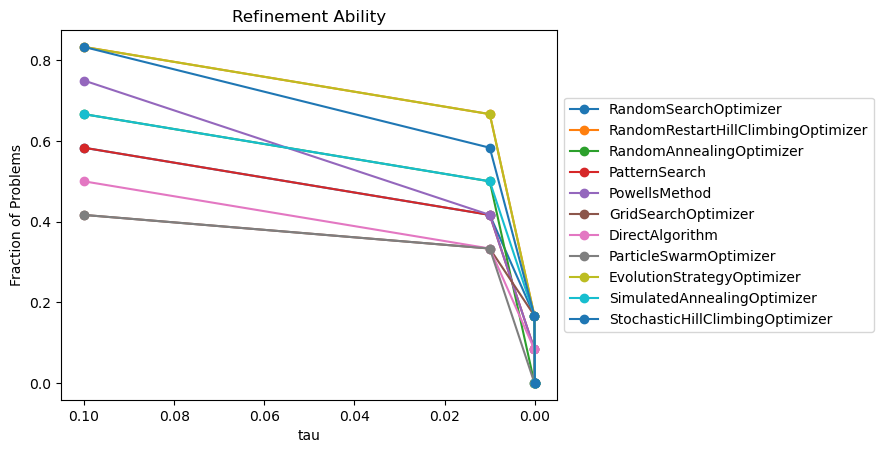

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for label, y in plot_dict.items():
    ax.plot(taus, y, 'o-', label=label)

ax.set_xlabel('tau')

plt.title(f"Refinement Ability")
ax.invert_xaxis()
ax.set_ylabel('Fraction of Problems')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()